In [1]:
!python --version
!pip show tobbo

Python 3.11.11
Name: tobbo
Version: 0.1.0
Summary: Topology Optimization with Black-Box Optimization methods
Home-page: https://github.com/jelle-westra/tobbo
Author: _______, _____________, _________
Author-email: ________@gmail.com
License: MIT
Location: /Users/jelle-westra/Documents/projects/tobbo/.venv/lib/python3.11/site-packages
Requires: cma, GPy, hebo, matplotlib, numpy, rasterio, scipy, shapely, tqdm
Required-by: 


In [2]:
# importing the usual suspects
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=18)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

plt.rcParams['axes.formatter.use_mathtext'] = True

# Install/Build `tobbo`

Build from local source:
- `(.venv) $ pip install package/` 

Or from PyPi (TODO):
- `(.venv) $ pip install ____`

# Minimal Example

Setting up a TO experiment with tobbo is four-fold:

1) **Domain** definition; setting up the Topology container.
2) **Parameterization** definition; a mapping for generating geometry from design vectors.
3) **Problem** definition; physics model, constraints, objective.
3) **Optimization**; using a BBO method for minimizing the objective.

Topology is used as data container for domain configuration, and holding the geometry in polygonal- and discretized binary mask form. This binary mask is used to activate material in the mesh of the physics model. The polygonal representation is used for calculation of the constraint functions. 

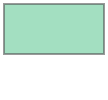

In [4]:
from tobbo.core import Topology

topology = Topology(False, (100, 50), 1.)

topology.domain

We use the rasterized polygonal geometry for calculating constraint (`continuous=False`), such that it is one-to-one with the physics mesh. Sometimes the underlying continuous geometry can be barely connected, whereas after rasterization this is not the case, this results to spurious calls to the physics simulation.

A `Parameterization` forms a mapping between the desgin space $[0,1]^d$ and generated geometry. 

In [5]:
from tobbo.parameterizations.mmc import Capsules, MMCEndpointsConfig

# Capsules is a subclass of Parameterization
parameterization = Capsules(topology, 
    symmetry_x=False, 
    symmetry_y=True,
    n_components=1, # no. components before mirroring
    representation=MMCEndpointsConfig, # see explaination below
    deformer=None, 
    n_samples=1000
)

`Capsules` generates beams with rounded caps, in this case we define a $y$-symmetry to mirror all generated beams among the horizontal centerline of the problem domain (see below). 

`representation` refers to the way we describe a beam; by its endpoints and radius in this case, but you can also define the representation to be `MMCAngularConfig` which uses a center point, angle and dimensions of the beam.

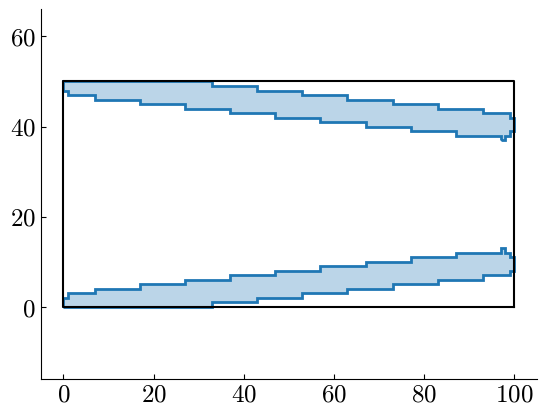

In [6]:
#            [x1 y1 x2 y2   r  ]
x = np.array([0, 0, 1, 0.2, 0.1])
parameterization.update_topology(topology, x)

topology.plot()

Under the hood `Topology` stores two representations of the geometry:
- Polygonal, used to calculate constraints; and
- Mask, a discretized binary mask which can be used by an FE model.

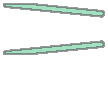

In [7]:
topology.geometry

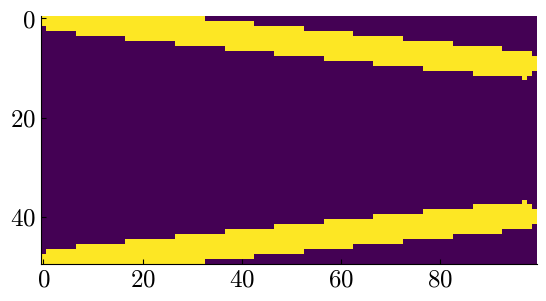

In [8]:
plt.imshow(topology.mask);

A `ProblemInstance` can be called with a trial vector which runs the simulation if constraints are met. 

`create_horizontal_cantilever_problem` set ups such a problem for the horizontal cantilever problem: wall on the left hand side and a load applied on the right side. In the section Problem Formulation it is explained how to setup a custom problem.

$$
f_\text{obj}(\mathbf{x}) = \begin{cases}
    g(\mathbf{x}) \text{ if } g(\mathbf{x}) > 0 \\
    f(\mathbf{x}) \text{ otherwise. }
\end{cases}
$$

That is, the simulation is only ran for legal configurations of the geometry (feasible), for infeasible designs the score of the constraint function is returned and the simulation budget is not decremented.

In [9]:
from tobbo.problems import create_horizontal_cantilever_problem

problem = create_horizontal_cantilever_problem(
    topology, 
    parameterization
)

In [10]:
# the physics model, being called when the trial vector is feasible
problem.model

In [11]:
# the constraint function
problem.topology_constraints

[ConstraintMix(weight=1, constraints=[VolumeConstraint(weight=1000.0, max_relative_volume=0.5), DisconnectionConstraint(weight=1000.0, topology=Topology(continuous=False, domain_size=(100, 50), density=1.0), boundaries=[<POINT (1 0.5)>, <LINESTRING (0 0, 0 1)>])], offset=500)]

In our case we sum two constraints: 
- `VolumeConstraint` $(g_1)$ penalizing the exceeded volume over a pre-specified budget.
- `DisconnectionConstraint` $(g_2)$ penalizing based on the least distance required to make the design connected, to itself, and to pre-specified boundary conditions.

$$
g(\mathbf{x}) = c_1g_1(\mathbf{x}) + c_2g_2(\mathbf{x}) + \max_{x'\in \mathcal{X}_\text{feasible}} f(\mathbf{x}')
$$

To create an artificial funnel structure towards the feasible region and to ensure this fitness is higher than the fitness of feasible desings the constraint function is offset with the worst (max) feasible design. For this problem we estimated this design would be around the compliance of 500 (a decent design is below 0.1).

In [12]:
from tobbo.core import run_experiment, OptimizationMethod

run_experiment(problem, 
    budget=100, 
    seed=1, 
    name='minimal-example', 
    method=OptimizationMethod.CMAES
)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1, Mon Oct 13 09:55:00 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.697056274847714e+02 1.0e+00 2.51e-01  2e-01  3e-01 0:00.0
    2     16 2.043857152229669e+00 1.3e+00 2.92e-01  3e-01  3e-01 0:00.3
    3     24 5.608504366272913e+02 1.5e+00 2.92e-01  2e-01  3e-01 0:00.3
   22    176 5.092354039324587e-01 2.9e+00 4.35e-02  2e-02  4e-02 0:04.0
   27    216 2.205799576087525e-01 3.7e+00 4.16e-02  2e-02  5e-02 0:09.3
   32    256 1.049632949995606e-01 4.3e+00 6.09e-02  2e-02  7e-02 0:14.6
[stop]


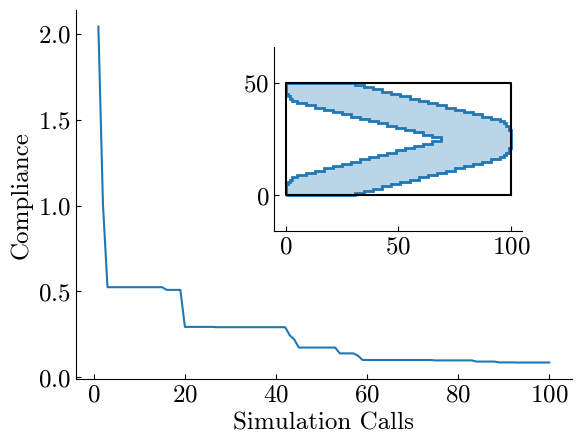

In [13]:
problem.plot_log()
plt.gca().set_yscale('linear')

# Parameterizations

# Parameterization Formulation

# Custom BBO Algorithm

In [14]:
from tobbo.core import ProblemInstance

import os
from scipy.optimize import minimize

def run_experiment_custom(
    problem: ProblemInstance,
    budget: int,
    seed: int,
    name: str,
) -> None:
    np.random.seed(seed)
    problem.logger_output_directory = f'./results/{name}/{seed}'
    os.makedirs(problem.logger_output_directory, exist_ok=True)
    problem.set_budget(budget)

    try:
        minimize(problem, problem.parameterization.gen_x0(), method='Nelder-Mead')
    except KeyboardInterrupt:
        pass
    print('[stop]')

In [15]:
from tobbo.parameterizations.mmc import MMCCenterpointsConfig

# Capsules is a subclass of Parameterization
parameterization = Capsules(topology, 
    symmetry_x=False, 
    symmetry_y=True,
    n_components=1, # no. components before mirroring
    representation=MMCCenterpointsConfig, 
    deformer=None, 
    n_samples=1000
)

problem: ProblemInstance = create_horizontal_cantilever_problem(
    topology, 
    parameterization
)

run_experiment_custom(problem, 100, 1, 'custom-bbo')

[stop]


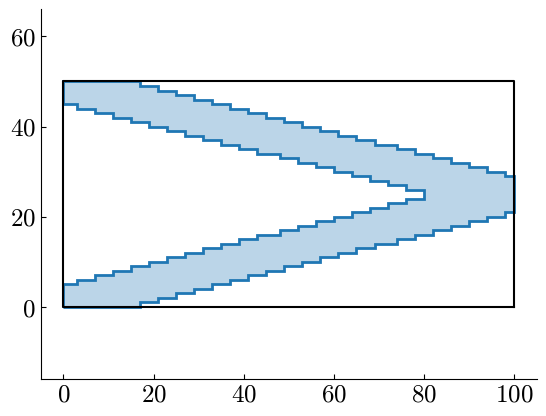

In [16]:
problem.plot_best()

# Problem Formulation 

In [17]:
from tobbo.core import Parameterization, Topology, ProblemInstance, VolumeConstraint, DisconnectionConstraint, ConstraintMix
from tobbo.models.membrane import BinaryElasticMembraneModel, RigidEdge, Load

from shapely.geometry import Point, LineString

def create_vertical_cantilever_problem(topology: Topology, parameterization: Parameterization) -> ProblemInstance :
    model = BinaryElasticMembraneModel(
        topology, thickness=1, E11=25, E22=1, G12=0.5, nu12=0.25, Emin=1e-9
    )
    # The Rigid Edge BC is now on the top of the domain instead of the left
    model.bcs.add(RigidEdge(
        nodes=model.mesh.nodes[-1, :], state=model.state)
    )
    # Load is now applied on the bottom middle node of the mesh
    model.bcs.add(Load(
        nodes=[model.mesh.nodes[0, model.mesh.nelx//2]], loads=[(-0.1, 0)])
    )
    topology_constraints = [
        VolumeConstraint(
            weight=1e3, 
            max_relative_volume=0.5
        ),
        DisconnectionConstraint(
            weight=1e3,
            topology=topology,
            boundaries=[
                # The the wall
                LineString([(0,topology.domain_size_y), (topology.domain_size_x,topology.domain_size_y)]),
                # The loading point:
                Point(topology.domain_size_x/2, 0),
            ]
        )
    ]
    constraint_mixer = ConstraintMix(1, topology_constraints, offset=500)
    objective = lambda model : model.compute_element_compliance().sum()
    return ProblemInstance(topology, parameterization, model, [constraint_mixer], objective)

In [18]:
topology = Topology(continuous=False, domain_size=(50,50), density=1.)

parameterization = Capsules(topology,
    symmetry_x=True, 
    symmetry_y=False,
    n_components=1,
    representation=MMCCenterpointsConfig,
    deformer=None,
    n_samples=1000
)

problem: ProblemInstance = create_vertical_cantilever_problem(
    topology, 
    parameterization
)

run_experiment(problem, 
    budget=100, 
    seed=3141, 
    name='vertical', 
    method=OptimizationMethod.DE
)

[stop]


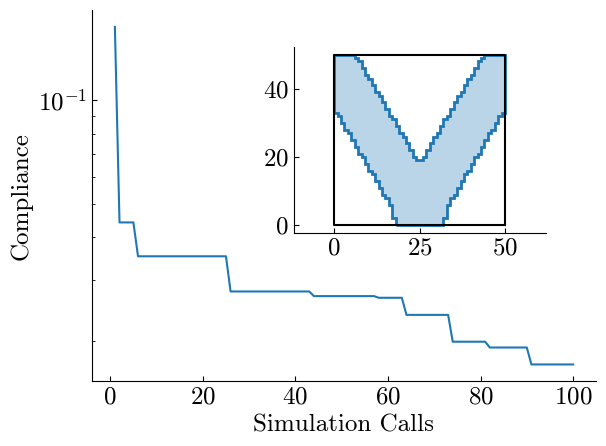

In [19]:
simulations = np.arange(1,problem.budget+1)
best_fitness = np.inf*np.ones(problem.budget, dtype=float)

best_fitness[[i-1 for i in problem.log['simulations']]] = problem.log['fitness']
best_fitness = np.minimum.accumulate(best_fitness)

fig, ax = plt.subplots()
ins = ax.inset_axes([0.4,0.4,0.5,0.5])

ax.semilogy(simulations, best_fitness)
problem.plot_best(ins)

ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()